# Iterators and Iterables

## Iterating Collections

When it comes to sequences, we performed iteration using \__getitem\__(0), \__getitem\__(1) etc.
But iteration can be more general than based on sequential indexing. <br>
All we need is:
- a bucket of items -> collection, container
- getting the next item logic -> no concept of ordering need, it's just a way to get items out of the container one by one. A specific order is not required but can be.

Sets are a good example of unordered collections in Python. They are iterable, but not indexable, meaning you cannot access elements by position. Additionally, since sets are unordered, the order in which elements are returned during iteration is not guaranteed and may vary.

In [1]:
s = {'x', 'y', 'z'}
# s[0]  # TypeError - 'set' object does not support indexing
for item in s:
    print(item)

z
y
x


For general iteration, all we really need is the concept of "get the next item" in the collection. <br>
If a collection object implements a get_next_item method, we can get element out of the collection, one after the other, this way: <br>
get_next_item(); get_next_item(); get_next_item()<br><br>
When all the elements of the collection have been returned by calling get_next_item, <b>StopIteration</b> exception should be raised.

Python has a built-in function: next(). <br>
We can implement that function for our custom type by implementing the special method: __next__.

In [2]:
class Squares:
    def __init__(self, length):
        self.i = 0
        self.length = length

    def __next__(self):
        if self.i >= self.length:
            raise StopIteration
        else:
            result = self.i ** 2
            self.i += 1
            return result


sq = Squares(5)
while True:
    try:
        item = next(sq)
        print(item)
    except StopIteration:
        break
        

0
1
4
9
16


In the example above, we have some issues:
- we cannot iteratre using for loops, comprehensions, etc.
- once the iteration starts we have no way of re-starting it and once all the items have been iterated (using next) the object becomes useless for iteration (<b>exhausted</b>).

In [1]:
import random

In [2]:
class RandomNumbers:
    def __init__(self, length, *, range_min=0, range_max=10):
        self.length = length
        self.range_min = range_min
        self.range_max = range_max
        self.num_requested = 0

    def __len__(self):
        return self.length

    def __next__(self):
        if self.num_requested >= self.length:
            raise StopIteration
        else:
            self.num_requested += 1
            return random.randint(self.range_min, self.range_max)
        

In [4]:
numbers = RandomNumbers(3)
print(next(numbers))
print(next(numbers))
print(next(numbers))

0
2
10


In [5]:
next(numbers) # exhausted, we have to create another instance of RandomNumbers

StopIteration: 

## Iterators

We created a custom container type object with a \_\_next\_\_ method, but it had several drawbacks:
- cannot use a for loop,
- once we start using next there's no going back,
- once we have reached StopIteration we're basically done with the object.

We saw how to iterate using \_\_next\_\_, StopIteration, and a while loop. This is actually how Python handles for loops in general.
Somehow, we need to tell Python that our class has that \_\_next\_\_ method and that it will behave in a way consistent with using a while loop to iterate.

A protocol is simply a fancy way of saying that our class is going to implement certain functionality that can count on. <br>
To let Python know our class can be iterated over using \_\_next\_\_ we implement the <b>iterator protocol</b>.
<br><br>
The iterator protocol is quite simple - the class needs to implement two methods:
- \_\_iter\_\_ -> this method should just return the object (class instance) itself,
- \_\_next\_\_ -> this method is resposnible for handling back the next element from collection and raising the StopIteration exception when all elements have been handed out.

An object that implements these two methods is called an <b>iterator</b>.<br>
If an object is an iterator, we can use it with for loops, comprehensions, etc.<br><br>
Still one issue though - the iterator cannot be "restarted". Once we have looped through all the items the iterator has been exhausted. To loop a second time through the collection we have to create a new instance and loop through that.

In [1]:
class Squares:
    def __init__(self, length):
        self.length = length
        self.i = 0

    def __next__(self):
        if self.i >= self.length:
            raise StopIteration
        else:
            result = self.i ** 2
            self.i += 1
            return result

    def __iter__(self):
        return self
        

In [2]:
sq = Squares(5)

In [3]:
for item in sq:
    print(item)

0
1
4
9
16


In [5]:
for item in sq: # sq iterator has been exhausted - we have to create a new instance to iterate through it
    print(item)

In [6]:
next(sq)

StopIteration: 

In [7]:
sq = Squares(5)

In [8]:
l = [(item, item + 1) for item in sq]
l

[(0, 1), (1, 2), (4, 5), (9, 10), (16, 17)]

In [10]:
l = [(item, item + 1) for item in sq] # sq iterator has been exhausted - we have to create a new instance to iterate through it
l

[]

In [11]:
sq = Squares(5)
list(enumerate(sq))

[(0, 0), (1, 1), (2, 4), (3, 9), (4, 16)]

In [13]:
list(enumerate(sq)) # sq iterator has been exhausted - we have to create a new instance to iterate through it

[]

In [14]:
sq = Squares(5)
sorted(sq, reverse=True)

[16, 9, 4, 1, 0]

In [16]:
sorted(sq, reverse=True) # sq iterator has been exhausted - we have to create a new instance to iterate through it

[]

When using an iterator in a for loop or a comprehension, Python calls \_\_iter\_\_ function in the first place.

In [17]:
class Squares:
    def __init__(self, length):
        self.length = length
        self.i = 0

    def __next__(self):
        print('__next__ called')
        if self.i >= self.length:
            raise StopIteration
        else:
            result = self.i ** 2
            self.i += 1
            return result

    def __iter__(self):
        print('__iter__ called')
        return self
        

In [18]:
sq = Squares(5)
list(enumerate(sq))

__iter__ called
__next__ called
__next__ called
__next__ called
__next__ called
__next__ called
__next__ called


[(0, 0), (1, 1), (2, 4), (3, 9), (4, 16)]

So basically Python does something like below.

In [19]:
sq = Squares(5)
sq_iterator = iter(sq)
while True:
    try:
        item = next(sq_iterator)
        print(item)
    except StopIteration:
        break

__iter__ called
__next__ called
0
__next__ called
1
__next__ called
4
__next__ called
9
__next__ called
16
__next__ called


## Iterator vs Iterable

We would prefer to seperate these two:
- maintaining the data of the collection should be one object,
- iterating over the data should be a separate object (iterator). That object is throw-away, but we don't throw away the collection.

The collection is <b>iterable</b>, but the <b>iterator</b> is reponsible for iterating over the collection. <br>
The iterable is created <b>once</b>. <br>
The iterator is created <b>every time</b> we need to start a fresh iteration.

So far, our Squares instances are iterators. 

An <b>iterable</b> is a Python object that implements the iterable protocol.

The iterable protocol requires that the object implement a single method:
- \_\_iter\_\_ -> returns a new instance of the iterator object used to iterate over the iterable.

An iterable is an object that implements:
- \_\_iter\_\_ -> returns an iterator (in general, a <b>new instance).

An iterator is an object that implements:
- \_\_iter\_\_ -> returns itself (an iterator - not a new instance)
- \_\_next\_\_ -> returns the next element.

Iterables never become exhausted because they always return a new iterator that is then used to iterate.

The first thing Python does when we try to iterate over an object:
- it calls iter() to obtain an iterator,
- then it starts iterating (using next, StopIteration, etc.) using the iterator returned by iter().

In [21]:
class Cities:
    def __init__(self):
        self._cities = ['Paris', 'Berlin', 'Rome', 'Madrid', 'London']

    def __len__(self):
        return len(self._cities)

    def __iter__(self):
        return CityIterator(self)


class CityIterator:
    def __init__(self, city_obj):
        self._city_obj = cities
        self._index = 0

    def __next__(self):
        if self._index >= len(self._city_obj):
            raise StopIteration
        else:
            item = self._city_obj._cities[self._index]
            self._index += 1
            return item

    def __iter__(self):
        return self
        

In [24]:
cities = Cities()  # an iterable
for city in cities:  # an instance of CityIterator is created
    print(city)

Paris
Berlin
Rome
Madrid
London


In [25]:
for city in cities: # we don't have to recreate the collection
    print(city)

Paris
Berlin
Rome
Madrid
London


Let's now add some print statements to see how things work behind the scenes.

In [39]:
class Cities:
    def __init__(self):
        self._cities = ['Paris', 'Berlin', 'Rome', 'Madrid', 'London']

    def __len__(self):
        return len(self._cities)

    def __iter__(self):
        print("Cities __iter__ called")
        return self.CityIterator(self)


    class CityIterator:
        def __init__(self, city_obj):
            print("New CityIterator instance created!")
            self._city_obj = cities
            self._index = 0
    
        def __next__(self):
            print("CityIterator __next__ called")
            if self._index >= len(self._city_obj):
                raise StopIteration
            else:
                item = self._city_obj._cities[self._index]
                self._index += 1
                return item
    
        def __iter__(self):
            print("CityIterator __iter__ called")
            return self
            

Each time an instance of Cities is iterated, a new instance of CityIterator is created.

In [40]:
cities = Cities()  # an iterable
for city in cities:
    print(city)

Cities __iter__ called
New CityIterator instance created!
CityIterator __next__ called
Paris
CityIterator __next__ called
Berlin
CityIterator __next__ called
Rome
CityIterator __next__ called
Madrid
CityIterator __next__ called
London
CityIterator __next__ called


In [41]:
for city in cities:
    print(city)

Cities __iter__ called
New CityIterator instance created!
CityIterator __next__ called
Paris
CityIterator __next__ called
Berlin
CityIterator __next__ called
Rome
CityIterator __next__ called
Madrid
CityIterator __next__ called
London
CityIterator __next__ called


In [42]:
c_iter_1 = cities.__iter__()
c_iter_2 = cities.__iter__()
print(c_iter_1, c_iter_2)

Cities __iter__ called
New CityIterator instance created!
Cities __iter__ called
New CityIterator instance created!
<__main__.Cities.CityIterator object at 0x000002558C51B290> <__main__.Cities.CityIterator object at 0x000002558C517850>


In [45]:
c_iter_1 is c_iter_2  # different objects

False

In [44]:
id(c_iter_1), id(c_iter_2)

(2566449640080, 2566449625168)

If our custom class was both a sequence and an iterable, Python would use its \_\_iter\_\_ function to iterate through the object. <br>
The way Python works is this:
- it tests if the class implements the iterator protocol and use it if it is implemented,
- if it doesn't find an iterator, then it tries to use \_\_getitem\_\_ method,
- else TypeError is raised.

In [26]:
l = [1, 2, 3, 4]

In [27]:
iter(l)

In [28]:
l.__getitem__

<function list.__getitem__>

In [29]:
l_iter = iter(l)
l_iter

In [30]:
for i in l_iter:
    print(i)

1
2
3
4


In [32]:
for i in l_iter:  # exhausted
    print(i)

In [33]:
next(l_iter)

StopIteration: 

In [34]:
s = {1, 2, 3}
iter(s)

In [35]:
s_iter = iter(s)

In [36]:
next(s_iter)

1

In [38]:
s.__getitem__  # set is not a sequence type so it does not support indexing

AttributeError: 'set' object has no attribute '__getitem__'

## Cyclic Iterators
Cyclic iterators cannot be exhausted. After iterating through the entire iterable, they start over from the beginning.

In [11]:
class CyclicIterator:
    def __init__(self, lst):
        self.lst = lst
        self.i = 0

    def __iter__(self):
        return self

    def __next__(self):
        result = self.lst[self.i % len(self.lst)]
        self.i += 1
        return result
        

In [12]:
iter_cycl = CyclicIterator('NSWE')

In [13]:
for _ in range(10):
    print(next(iter_cycl))

N
S
W
E
N
S
W
E
N
S


In [15]:
numbers = list(range(1, 11))
iter_cycl = CyclicIterator('NSWE')

In [16]:
list(zip(numbers, iter_cycl)) # numbers will get exhausted earlier - it stops the iteration

[(1, 'N'),
 (2, 'S'),
 (3, 'W'),
 (4, 'E'),
 (5, 'N'),
 (6, 'S'),
 (7, 'W'),
 (8, 'E'),
 (9, 'N'),
 (10, 'S')]

In [17]:
list(zip(numbers, 'NSWE' * 30))  # but not as efficient as cyclic iterator when the first sequence is big

[(1, 'N'),
 (2, 'S'),
 (3, 'W'),
 (4, 'E'),
 (5, 'N'),
 (6, 'S'),
 (7, 'W'),
 (8, 'E'),
 (9, 'N'),
 (10, 'S')]

In [24]:
import itertools

# itertools.cycle() is a method that can make a cycling iterator out of the given iterable
iter_cycl = itertools.cycle('NSWE')
n = 10
list(zip(list(range(1, n + 1)), iter_cycl))

[(1, 'N'),
 (2, 'S'),
 (3, 'W'),
 (4, 'E'),
 (5, 'N'),
 (6, 'S'),
 (7, 'W'),
 (8, 'E'),
 (9, 'N'),
 (10, 'S')]

In [26]:
help(itertools.cycle)  # we can pass an iterable also

Help on class cycle in module itertools:

class cycle(builtins.object)
 |  cycle(iterable, /)
 |  
 |  Return elements from the iterable until it is exhausted. Then repeat the sequence indefinitely.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __setstate__(...)
 |      Set state information for unpickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



We can easily implement a cyclic iterator by ourselves.

In [27]:
class CyclicIterator:
    def __init__(self, iterable):
        self.iterable = iterable
        self.iterator = iter(self.iterable) # basically creating a new iterator

    def __iter__(self):
        return self

    def __next__(self):
        try:
            item = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.iterable) # once an iterator is exhausted, we create a new one and iterate through it
            item = next(self.iterator)
        finally:
            return item
            

In [28]:
iter_cycl = CyclicIterator('abc')

In [29]:
for i in range(10):
    print(i, next(iter_cycl))

0 a
1 b
2 c
3 a
4 b
5 c
6 a
7 b
8 c
9 a


## Lazy Iterables

Lazy Evaluation - it is often used in class properties. <br>
It means that properties of classes may not always be populated when the object is created and/or the value of a property only becomes known when the property is requested - deferred.

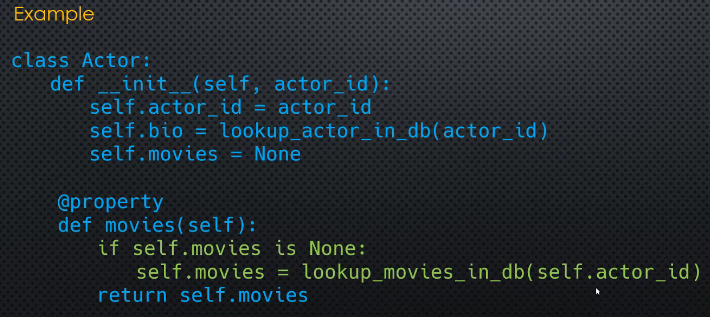

We can apply the same concept to certain iterables. We do not calculate the next item in an iterable until it is actually requested. <br>

Example:<br>
iterable -> Factorial(n)<br>
    - will return factorials of consecutive integers from 0 to n - 1,<br>
    - do not pre-compute all the factorials,<br>
    - wait unil next requests one, then calculate it.<br>
That is the form of lazy evaluation.

Using that lazy evaluation technique menas that we can actually have infinite iterables. Since items are not computed until they are requested, we can have an infinite number of items in the collection.

In [3]:
import math

In [4]:
class Circle:
    def __init__(self, r):
        self.radius = r
        self._area = None

    @property
    def radius(self):
        return self._radius

    @radius.setter
    def radius(self, r):
        self._radius = r
        self._area = None

    @property
    def area(self):
        if self._area is None:
            print('Calculating area...')
            self._area = math.pi * (self.radius ** 2)
        return self._area
        

In [12]:
c = Circle(1)

In [13]:
c.area

Calculating area...


3.141592653589793

In [14]:
c.area

3.141592653589793

In [15]:
c.radius = 2

In [16]:
c.area

Calculating area...


12.566370614359172

In [24]:
class Factorials:
    # iterable does very little
    def __iter__(self):
        return self.FactIter()

    class FactIter:
        # iterator does most of the work
        def __init__(self):
            self.i = 0

        def __iter__(self):
            return self

        def __next__(self):
            result = math.factorial(self.i)
            self.i += 1
            return result
                

In [25]:
facts = Factorials()

In [26]:
fact_iter = iter(facts)

In [27]:
next(fact_iter), next(fact_iter), next(fact_iter)

(1, 1, 2)

In [28]:
next(fact_iter)

6

## Python's Built-In Iterables and Iterators

Python provides many functions that return iterables or iterators. Additionally, the iterators perform lazy evaluation. <br>
range(10) -> iterable <br>
zip(l1, l2) -> iterator <br>
enumerate(l1) -> iterator <br>
open('cars.csv') -> iterator <br>
dictionary.keys() -> iterable <br>
dictionary.values() -> iterable <br>
dictionary.items() -> iterable <br>
...

In [1]:
r = range(10)
r

range(0, 10)

In [2]:
type(r)

range

In [3]:
print('__iter__' in dir(r))
print('__next__' in dir(r))

True
False


In [4]:
iter(r)

In [5]:
[num for num in r]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
z = zip([1, 2, 3], 'abc')
z

In [7]:
print('__iter__' in dir(z))
print('__next__' in dir(z))

True
True


In [8]:
list(z)

[(1, 'a'), (2, 'b'), (3, 'c')]

In [11]:
list(z)  # exhausted -> returns an empty list

[]

In [13]:
with open('file.txt') as f:
    print(type(f))
    print('__iter__' in dir(f))
    print('__next__' in dir(f))
    print(iter(f) is f)

<class '_io.TextIOWrapper'>
True
True
True


In [14]:
with open('file.txt') as f:
    l = f.readlines()

l

['a,b,c,d,e\n', '1,2,3,4,5\n', '6,7,8,9,10\n', '11,12,13,14,15']

In [15]:
e = enumerate('Python Rocks!')
type(e)

enumerate

In [16]:
iter(e) is e

True

In [17]:
print('__next__' in dir(e))

True


In [18]:
list(e)

[(0, 'P'),
 (1, 'y'),
 (2, 't'),
 (3, 'h'),
 (4, 'o'),
 (5, 'n'),
 (6, ' '),
 (7, 'R'),
 (8, 'o'),
 (9, 'c'),
 (10, 'k'),
 (11, 's'),
 (12, '!')]

In [20]:
list(e)  # exhausted

[]

In [21]:
d = {'a': 1, 'b': 2}
keys = d.keys()
keys

dict_keys(['a', 'b'])

In [22]:
iter(keys) is keys  # if iter(keys) were keys (the same object), then keys would be an iterator, not an iterable

False

In [23]:
# we can check if an object is an iterable by checking if it has methods __iter__ and __next__
print('__iter__' in dir(keys))
print('__next__' in dir(keys))

True
False


## Sorting Iterables

sorted() function can take any iterable as an argument.

In [24]:
import random

In [25]:
random.seed(0)

In [32]:
class RandomInts:
    def __init__(self, length, *, seed=0, lower=0, upper=10):
        self.length = length
        self.seed = seed
        self.lower = lower
        self.upper = upper

    def __len__(self):
        return self.length

    def __iter__(self):
        return self.RandomIterator(self.length, seed=self.seed, lower=self.lower, upper=self.upper)

    class RandomIterator:
        def __init__(self, length, *, seed, lower, upper):
            self.length = length
            self.lower = lower
            self.upper = upper
            self.num_requests = 0
            random.seed(seed)

        def __iter__(self):
            return self

        def __next__(self):
            if self.num_requests >= self.length:
                raise StopIteration
            else:
                result = random.randint(self.lower, self.upper)
                self.num_requests += 1
                return result


In [27]:
randoms = RandomInts(10)
for num in randoms:
    print(num)

6
6
0
4
8
7
6
4
7
5


In [28]:
for num in randoms:
    print(num)

6
6
0
4
8
7
6
4
7
5


In [29]:
randoms = RandomInts(10, seed=None)
for num in randoms:
    print(num)

0
10
4
5
4
5
2
9
2
3


In [30]:
randoms = RandomInts(10, seed=None)
for num in randoms:
    print(num)

0
5
5
7
4
4
7
1
8
6


In [33]:
randoms = RandomInts(10)
list(randoms)

[6, 6, 0, 4, 8, 7, 6, 4, 7, 5]

In [35]:
sorted(randoms, reverse=True)

[8, 7, 7, 6, 6, 6, 5, 4, 4, 0]

## The iter() function

When Python performs an iteration over an iterable the very first thing it does is call the iter() function on the object we want to iterate. If the object implements the \_\_iter\_\_ method, that method is called and Python uses the <b>returned iterator</b>.

But what happens if the object does not implement the \_\_iter\_\_ method?

Python do not always calls the \_\_iter\_\_ method, but it calls the <b>iter()</b> function. <br>
In fact if obj is an object that only implements \_\_getitem\_\_, iter(obj) returns an iterator type object!

So when iter(obj) is called:
1. Python first looks for an __iter__method
    - if it's there, use it
    - it it's not, look for a \_\_getitem\_\_ method:
        - if it's there create an iterator object and return that
        - if it's not there, raise a TypeError exception (not iterable)

The easiest approach to test if an object is iterable is to try to use iter() function on that object. If it raises TypeError then the object is not an iterable.

In [37]:
l = [1, 2, 3, 4]
l_iter = iter(l)
type(l_iter)

list_iterator

In [38]:
next(l_iter)

1

In [40]:
class Squares:
    def __init__(self, n):
        self._n = n

    def __len__(self):
        return self._n

    def __getitem__(self, i):
        if i>= self._n:
            raise IndexError
        else:
            return i ** 2
            

In [41]:
sq = Squares(5)

In [42]:
for i in sq:
    print(i)

0
1
4
9
16


In [43]:
sq_iter = iter(sq)
type(sq_iter)

iterator

In [44]:
'__next__' in dir(sq_iter)

True

In [45]:
print(next(sq_iter))
print(next(sq_iter))

0
1


In [46]:
class Squares_2:
    def __init__(self, n):
        self._n = n

    def __len__(self):
        return self._n
        

In [47]:
sq_iter = iter(Squares_2(5))

TypeError: 'Squares_2' object is not iterable

In [53]:
class SequenceIterator:
    def __init__(self, seq):
        self._seq = seq
        self._i = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self._i >= len(self._seq):
            raise StopIteration
        else:
            result = self._seq[self._i]
            self._i += 1
            return result
            

In [54]:
sq = Squares(5)
sq_iterator = SquaresIterator(sq)

In [55]:
for item in sq_iterator:
    print(item)

0
1
4
9
16


In [56]:
for item in sq_iterator:  # exhausted
    print(item)

In [57]:
class SimpleIter:
    def __init__(self):
        pass

    def __iter__(self):
        return 'Nope'
        

In [58]:
s = SimpleIter()

In [59]:
'__iter__' in dir(s)

True

In [61]:
iter(s)

TypeError: iter() returned non-iterator of type 'str'

In [62]:
def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False
        

In [63]:
is_iterable(s)

False

In [64]:
is_iterable(Squares(5))

True

## Iterating Callables
Iterating over the return values of a callable.

Consider a callable that provides a countdown from start value: <br>
countdown() -> 3 <br>
countdown() -> 2 <br>
countdown() -> 1 <br>
countdown() -> 0 <br>
We wan to run a loop that will call countdown() until 0 is reached.

We could take a different approach, using iterators, and we can also make it quite generic. <br>
Make an iterator that knows two things:
- the callable that needs to be called,
- a value (the sentinel) that will result in a StopIteration if the callable returns that value.
<br><br>

The iterator would then be implemented as follows: <br>
when next() is called:
- call the callable and get the result,
- if the result is equal to the snetinel -> StopIteration and "exhaust" the iterator,
- otherwise return the result.

iter() can generate an iterator for us automatically.

In [2]:
help(iter)

Help on built-in function iter in module builtins:

iter(...)
    iter(iterable) -> iterator
    iter(callable, sentinel) -> iterator
    
    Get an iterator from an object.  In the first form, the argument must
    supply its own iterator, or be a sequence.
    In the second form, the callable is called until it returns the sentinel.



The second form of iter will return an iterator that will:
- call the callable when next() is called,
- and either raise StopIteration if the result is equal to the sentinel value,
- or return the result otherwise.

In [9]:
import random

# lambda function is our callable, and 8 is our sentinel value
# if 8 is returned by the lambda function, then the iteration stops
random_iter = iter(lambda: random.randint(0, 10), 8)
for num in random_iter:
    print(num)

3
2
5
0


In [15]:
def counter(n):
    def dec():
        nonlocal n
        n -= 1
        return n
    return dec
    

In [16]:
takeoff = counter(10)
count_iter = iter(takeoff, -1)
for num in count_iter:
    print(num)

9
8
7
6
5
4
3
2
1
0


## Delegating Iterators
Iterator delegation is a programming pattern where a class or function forwards iteration tasks to another iterable or iterator rather than implementing the iteration logic itself, e.g. using a list iterator in the \_\_iter\_\_ method instead of implementing the iterator for the custom class.

In [17]:
from collections import namedtuple

Person = namedtuple('Person', 'first last')

In [18]:
class PersonNames:
    def __init__(self, persons):
        try: 
            self._persons = [person.first.capitalize() + ' ' + person.last.capitalize() for person in persons]
        except (TypeError, AttributeError):
            self._persons = []
            

In [19]:
persons = [Person('michaeL', 'paLin'), Person('eric', 'idle'), Person('John', 'cLeese')]

In [20]:
person_names = PersonNames(persons)

In [22]:
person_names._persons

['Michael Palin', 'Eric Idle', 'John Cleese']

In [23]:
for name in person_names: # we cannot iterate PersonNames object
    print(name)

TypeError: 'PersonNames' object is not iterable

In [24]:
class PersonNames:
    def __init__(self, persons):
        try: 
            self._persons = [person.first.capitalize() + ' ' + person.last.capitalize() for person in persons]
        except (TypeError, AttributeError):
            self._persons = []

    def __iter__(self):
        return iter(self._persons)  # delegating to the list iterator


In [25]:
person_names = PersonNames(persons)
person_names._persons

['Michael Palin', 'Eric Idle', 'John Cleese']

In [26]:
for name in person_names: # now we can
    print(name)

Michael Palin
Eric Idle
John Cleese


## Reversed Iteration

If we have a sequence type, then iterating over the sequence in reverse orde is quite simple:
- for item in seq\[::-1]: -> this works, but it wasteful because it makes a copy of the sequence,
- for i in range(len(seq) - 1, -1, -1) -> more efficient, but the syntax is messy.
- for item in reversed(seq): -> this is cleaner and just as efficient, because it creates an <b>iterator</b> that will iterate backwards over the sequence = it does not copy the data, but both \_\_getitem\_\_ and \_\_len\_\_ must be implemented. <br><br>
We can override how reversed works by implementing the \_\_reversed\_\_ special method.

Unfortunately, reversed() will not work with custom iterables without a little bit of extra work. <br>
When we call reversed() on a custom iterable, Python will look for and call the \_\_reversed\_\_ function. That function should <b>return an iterator</b> that will be used to perform the reversed iteration. So basically we have to implement a reverse iterator ourselves.<br>
Just like the iter() method, when we call reversed() on an object:
- it looks for and calls \_\_reversed\_\_ method,
- if it's not there, uses \_\_getitem\_\_ and \_\_len\_\_ to create an iterator for us,
- exception otherwise.

In our exercise, we assume that we have a deck of 52 sorted cards: 2 Spade .. Ace Spades, 2 Hearts ... Ace Hearts, 2 Diamonds ... Ace Diamonds, 2 Clubs ... Ace Clubs. <br> What's more we don't want to create a list containing all the pre-created cards, but use lazy evaluation instead.

In [4]:
SUITS = ['Spades', 'Hearts', 'Diamonds', 'Clubs']  # len(SUITS) = 4
RANKS = [*range(2, 11), 'J', 'Q', 'K', 'A']  # len
RANKS

[2, 3, 4, 5, 6, 7, 8, 9, 10, 'J', 'Q', 'K', 'A']

In [6]:
from collections import namedtuple

Card = namedtuple('Card', 'rank suit')

In [11]:
class CardDeck:
    def __init__(self):
        self.length = len(SUITS) * len(RANKS)

    def __len__(self):
        return self.length

    def __iter__(self):
        return self.CardDeckIterator(self.length)

    class CardDeckIterator:
        def __init__(self, length):
            self.length = length
            self.i = 0

        def __iter__(self):
            return self

        def __next__(self):
            if self.i >= self.length:
                raise StopIteration
            else:
                suit = SUITS[self.i // len(RANKS)]
                rank = RANKS[self.i % len(RANKS)]
                self.i += 1
                return Card(rank, suit)
                

In [12]:
deck = list(CardDeck())
deck

[Card(rank=2, suit='Spades'),
 Card(rank=3, suit='Spades'),
 Card(rank=4, suit='Spades'),
 Card(rank=5, suit='Spades'),
 Card(rank=6, suit='Spades'),
 Card(rank=7, suit='Spades'),
 Card(rank=8, suit='Spades'),
 Card(rank=9, suit='Spades'),
 Card(rank=10, suit='Spades'),
 Card(rank='J', suit='Spades'),
 Card(rank='Q', suit='Spades'),
 Card(rank='K', suit='Spades'),
 Card(rank='A', suit='Spades'),
 Card(rank=2, suit='Hearts'),
 Card(rank=3, suit='Hearts'),
 Card(rank=4, suit='Hearts'),
 Card(rank=5, suit='Hearts'),
 Card(rank=6, suit='Hearts'),
 Card(rank=7, suit='Hearts'),
 Card(rank=8, suit='Hearts'),
 Card(rank=9, suit='Hearts'),
 Card(rank=10, suit='Hearts'),
 Card(rank='J', suit='Hearts'),
 Card(rank='Q', suit='Hearts'),
 Card(rank='K', suit='Hearts'),
 Card(rank='A', suit='Hearts'),
 Card(rank=2, suit='Diamonds'),
 Card(rank=3, suit='Diamonds'),
 Card(rank=4, suit='Diamonds'),
 Card(rank=5, suit='Diamonds'),
 Card(rank=6, suit='Diamonds'),
 Card(rank=7, suit='Diamonds'),
 Card(rank

In [13]:
reversed_deck = reversed(CardDeck())  # there is no __reversed__ method implemented in CardDeck

TypeError: 'CardDeck' object is not reversible

In [14]:
class CardDeck:
    def __init__(self):
        self.length = len(SUITS) * len(RANKS)

    def __len__(self):
        return self.length

    def __iter__(self):
        return self.CardDeckIterator(self.length)

    def __reversed__(self):
        return self.CardDeckIterator(self.length, reverse=True)
        
    class CardDeckIterator:
        def __init__(self, length, reverse=False):
            self.length = length
            self.reverse = True
            self.i = 0

        def __iter__(self):
            return self

        def __next__(self):
            if self.i >= self.length:
                raise StopIteration
            else:
                if self.reverse:
                    index = (self.length - 1 - self.i) 
                else:
                    index = self.i
                suit = SUITS[index // len(RANKS)]
                rank = RANKS[index % len(RANKS)]
                self.i += 1
                return Card(rank, suit)
                

In [15]:
deck = reversed(CardDeck())

In [16]:
list(deck)

[Card(rank='A', suit='Clubs'),
 Card(rank='K', suit='Clubs'),
 Card(rank='Q', suit='Clubs'),
 Card(rank='J', suit='Clubs'),
 Card(rank=10, suit='Clubs'),
 Card(rank=9, suit='Clubs'),
 Card(rank=8, suit='Clubs'),
 Card(rank=7, suit='Clubs'),
 Card(rank=6, suit='Clubs'),
 Card(rank=5, suit='Clubs'),
 Card(rank=4, suit='Clubs'),
 Card(rank=3, suit='Clubs'),
 Card(rank=2, suit='Clubs'),
 Card(rank='A', suit='Diamonds'),
 Card(rank='K', suit='Diamonds'),
 Card(rank='Q', suit='Diamonds'),
 Card(rank='J', suit='Diamonds'),
 Card(rank=10, suit='Diamonds'),
 Card(rank=9, suit='Diamonds'),
 Card(rank=8, suit='Diamonds'),
 Card(rank=7, suit='Diamonds'),
 Card(rank=6, suit='Diamonds'),
 Card(rank=5, suit='Diamonds'),
 Card(rank=4, suit='Diamonds'),
 Card(rank=3, suit='Diamonds'),
 Card(rank=2, suit='Diamonds'),
 Card(rank='A', suit='Hearts'),
 Card(rank='K', suit='Hearts'),
 Card(rank='Q', suit='Hearts'),
 Card(rank='J', suit='Hearts'),
 Card(rank=10, suit='Hearts'),
 Card(rank=9, suit='Hearts'),


## Caveat of Using Iterators as Function Arguments

In [17]:
import random

In [18]:
class Randoms:
    def __init__(self, n):
        self.n = n
        self.i = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.i >= self.n:
            raise StopIteration
        else:
            self.i += 1
            return random.randint(0, 100)
            

In [19]:
random.seed(0)

In [20]:
l = Randoms(10)
min(l)  # we exhaust l here

5

In [21]:
max(l)

ValueError: max() arg is an empty sequence

In [22]:
next(l)

StopIteration: 

## Project

### Goal 1
Refactor the Polygon class (from sequence types project section) so that all the calculated properties are lazy properties, i.e. they should still be calculated properties, but they should not have to get recalculated more than once.

Polygon class before:

In [ ]:
import math


class Polygon:
    def __init__(self, n, R):
        if not isinstance(n, int) or n < 3:
            raise ValueError('n parameter has to be an integer larger than or equal to 3')
        if not isinstance(R, (float, int)) or R <= 0:
            raise ValueError('R parameter has to be a postive real number')
        self._n = n
        self._R = R

    def __repr__(self):
        return f'Polygon(n={self._n}, R={self._R})'

    @property
    def count_vertices(self):
        return self._n

    @property 
    def count_edges(self):
        return self._n

    @property
    def circumradius(self):
        return self._R

    @property
    def interior_angle(self):
        return (self._n - 2) * 180 / self._n

    @property
    def side_length(self):
        return 2 * self._R * math.sin(math.pi / self._n)

    @property
    def apothem(self):
        return self._R * math.cos(math.pi / self._n)

    @property
    def area(self):
        return self._n / 2 * self.side_length * self.apothem

    @property
    def perimeter(self):
        return self._n * self.side_length
        
    def __eq__(self, other):
        if isinstance(other, Polygon):
            return self.count_edges == other.count_edges and self.circumradius == other.circumradius
        return NotImplemented

    def __gt__(self, other):
        if isinstance(other, Polygon):
            return self.count_edges > other.count_edges
        return NotImplemented
        

After:

In [3]:
import math


class Polygon:
    def __init__(self, n, R):
        if not isinstance(n, int) or n < 3:
            raise ValueError('n parameter has to be an integer larger than or equal to 3')
        if not isinstance(R, (float, int)) or R <= 0:
            raise ValueError('R parameter has to be a postive real number')
        self._n = n
        self._R = R
        self._interior_angle = None
        self._side_length = None
        self._apothem = None
        self._area = None
        self._perimeter = None

    def __repr__(self):
        return f'Polygon(n={self._n}, R={self._R})'

    @property
    def count_vertices(self):
        return self._n

    @property 
    def count_edges(self):
        return self._n

    @property
    def circumradius(self):
        return self._R

    @property
    def interior_angle(self):
        if self._interior_angle is None:
            return (self._n - 2) * 180 / self._n
        return self._interior_angle

    @property
    def side_length(self):
        if self._side_length is None:
            return 2 * self._R * math.sin(math.pi / self._n)
        return self._side_length

    @property
    def apothem(self):
        if self._apothem is None:
            return self._R * math.cos(math.pi / self._n)
        return self._apothem

    @property
    def area(self):
        if self._area is None:
            return self._n / 2 * self.side_length * self.apothem
        return self._area

    @property
    def perimeter(self):
        if self._perimeter is None:
            return self._n * self.side_length
        return self._perimeter
        
    def __eq__(self, other):
        if isinstance(other, Polygon):
            return self.count_edges == other.count_edges and self.circumradius == other.circumradius
        return NotImplemented

    def __gt__(self, other):
        if isinstance(other, Polygon):
            return self.count_edges > other.count_edges
        return NotImplemented
        

In [4]:
def test_polygon():

    try:
        p = Polygon(2, 10)
        assert False, 'Creating a Polygon with 2 sides: exception expected, but not received'
    except ValueError:
        pass

    try:
        p = Polygon(3, -1)
        assert False, 'Creating a Polygon with negative cirmuradius: exception expected, but not received'
    except ValueError:
        pass
    
    n = 3
    R = 1
    p = Polygon(n, R)
    assert str(p) == f'Polygon(n=3, R=1)', f'actual: {str(p)}'
    assert p.count_vertices == 3, f'actual: {p.count_vertices}, expected: {n}'
    assert p.count_edges == 3, f'actual: {p.count_edges}, expected: {n}'
    assert p.circumradius == 1, f'actual: {p.circumradius}, expected: {R}'
    assert p.interior_angle == 60, f'actual: {p.interior_angle}, expected: 60'
    assert p.side_length == math.sqrt(3), f'actual: {p.side_length}, expected: {math.sqrt(3)}'
    assert math.isclose(p.apothem, 0.5), f'actual: {p.apothem}, expected: 0.5'
    assert math.isclose(p.area, 3 / 4 * math.sqrt(3)), f'actual: {p.area}, expected: {3 / 4 * math.sqrt(3)}'
    assert math.isclose(p.perimeter, 3 * math.sqrt(3)), f'actual: {p.perimeter}, expected: {3 * math.sqrt(3)}'

    n1, n2, n3 = 5, 6, 6
    R1, R2, R3 = 1, 3, 3
    p1 = Polygon(n1, R1)
    p2 = Polygon(n2, R2)
    p3 = Polygon(n3, R3)
    assert p1 != p2
    assert p2 == p3
    assert not(p1 > p2)
    assert p2 > p1
    assert not(p3 < p2)
  

In [5]:
test_polygon()

### Goal 2
Refactor the Polygons (sequence) type into an interable. Make sure also that the elements in the iterator are computed lazily - i.e. you can no longer use a list as an underlying storage mechanism for your polygons. You'll need to implement both an iterable, and an iterator.

Before:

In [23]:
class Polygons:
    def __init__(self, m, R):
        if not isinstance(m, int) or m < 3:
            raise ValueError('m parameter has to be an integer larger than or equal to 3')
        if not isinstance(R, (float, int)) or R <= 0:
            raise ValueError('R parameter has to be a positive real number')
        self._m = m
        self._R = R
        self._polygons = [Polygon(i, R) for i in range(3, m + 1)]

    def __len__(self):
        return self._m - 2

    def __repr__(self):
        return f'Polygons(m={self._m}, R={self._R})'

    def __getitem__(self, s):
        return self._polygons[s]

    @property
    def max_efficiency_polygon(self):
        return sorted(self._polygons, key=lambda p: p.area / p.perimeter)[-1]
        

After:

In [24]:
class Polygons:
    def __init__(self, m, R):
        if not isinstance(m, int) or m < 3:
            raise ValueError('m parameter has to be an integer larger than or equal to 3')
        if not isinstance(R, (float, int)) or R <= 0:
            raise ValueError('R parameter has to be a positive real number')
        self._m = m
        self._R = R

    def __len__(self):
        return self._m - 2

    def __repr__(self):
        return f'Polygons(m={self._m}, R={self._R})'

    def __iter__(self):
        return self.PolygonsIterator(self._m, self._R)

    class PolygonsIterator:
        def __init__(self, m, R):
            if not isinstance(m, int) or m < 3:
                raise ValueError('m parameter has to be an integer larger than or equal to 3')
            if not isinstance(R, (float, int)) or R <= 0:
                raise ValueError('R parameter has to be a positive real number')
            self._m = m
            self._R = R
            self._i = 3  # i is the number of sides, must be at least 3

        def __iter__(self):
            return self

        def __next__(self):
            if self._i > self._m:
                raise StopIteration
            else:
                result = Polygon(self._i, self._R)
                self._i += 1
                return result

    @property
    def max_efficiency_polygon(self):
        return sorted(iter(self), key=lambda p: p.area / p.perimeter)[-1]
        

In [25]:
p_iter = iter(Polygons(6, 3))

In [26]:
type(p_iter)

__main__.Polygons.PolygonsIterator

In [27]:
for pol in p_iter:
    print(pol), print(type(pol))

Polygon(n=3, R=3)
<class '__main__.Polygon'>
Polygon(n=4, R=3)
<class '__main__.Polygon'>
Polygon(n=5, R=3)
<class '__main__.Polygon'>
Polygon(n=6, R=3)
<class '__main__.Polygon'>


In [28]:
next(p_iter)  # OK, it has been exhausted in the cell before

StopIteration: 

In [29]:
Polygons(6, 3).max_efficiency_polygon

Polygon(n=6, R=3)